In [2]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *

sampling_indices = (3, 4)

## Generate many objects in parallel

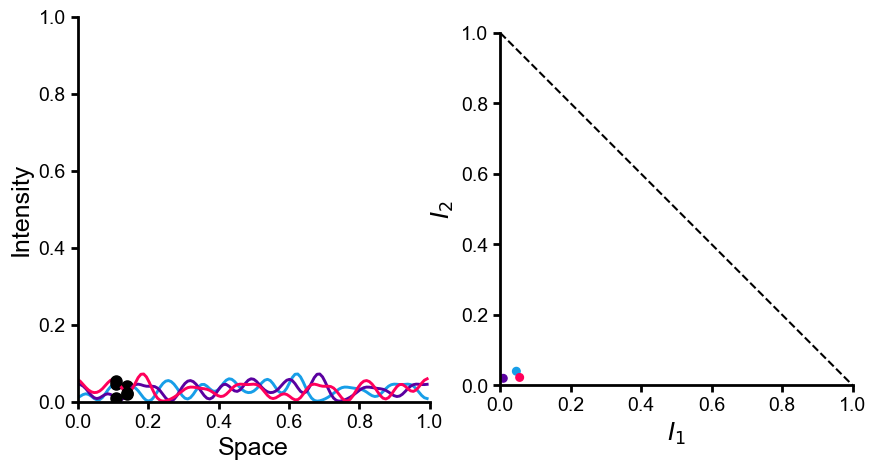

In [2]:
n_objects = 20
objects = np.array([sample_amplitude_object('delta') for i in range(n_objects)])

# generate random convolution kernel
random_kernel = bandlimited_nonnegative_signal(nyquist_samples=generate_random_bandlimited_signal())
conv_mat = make_convolutional_encoder(random_kernel)

output_signals = objects @ conv_mat.T 


sampling_indices = (3, 4)
num_to_plot = 3

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_in_spatial_coordinates(ax[0], output_signals[:num_to_plot], sample_point_indices=sampling_indices)
plot_in_intensity_coordinates(ax[1], output_signals[:num_to_plot], sample_point_indices=sampling_indices, differentiate_colors=True)

## Show example objects

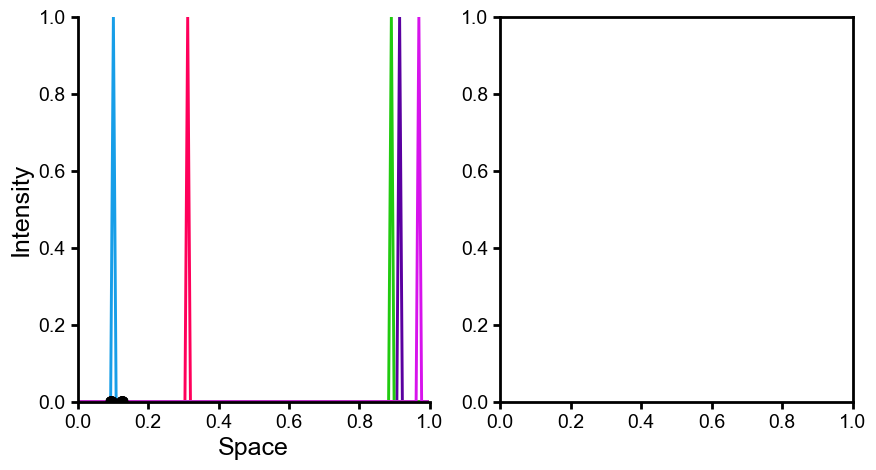

In [3]:
n_objects = 5
objects = np.array([sample_amplitude_object('delta') for i in range(n_objects)])
# objects = np.array([sample_amplitude_object('sinusoid', sin_freq_range=(9, 10)) for i in range(n_objects)])

# plot all the objects
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_in_spatial_coordinates(ax[0], objects, sample_point_indices=sampling_indices, plot_lim=1)

## Optimize an encoder based on entropy as a loss function

initial loss 294.9430009917037


Text(0.5, 1.0, 'Object')

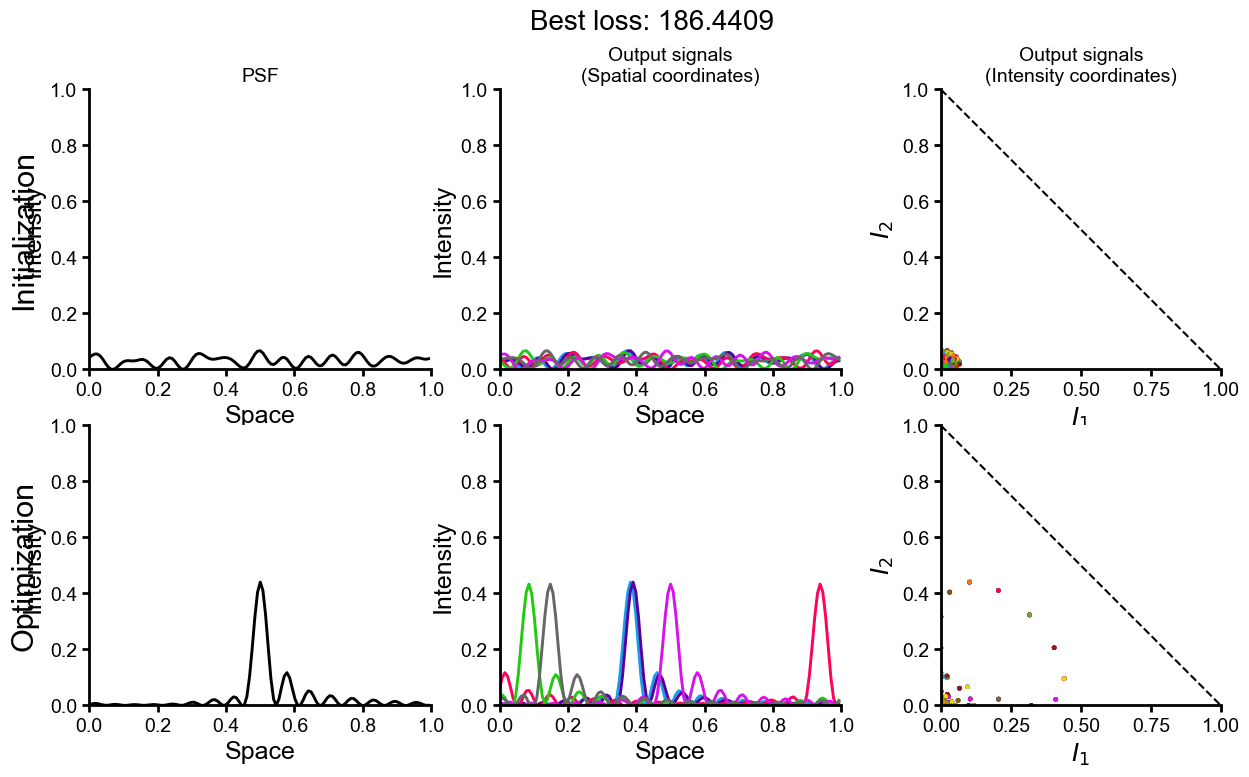

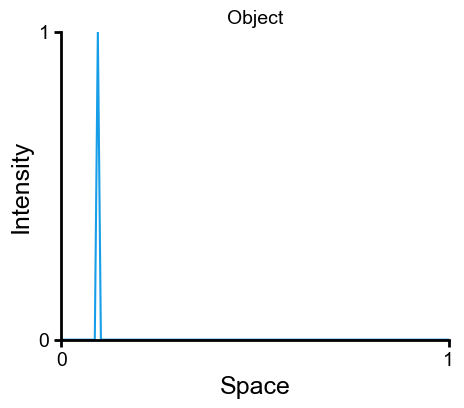

In [4]:
N_objects = 2000
N_objects_to_plot = 1
N_signals_to_plot = 6
erasure_mask = onp.ones(NUM_NYQUIST_SAMPLES)
# erasure_mask[erasure_mask.size // 4:] = 0
erasure_mask = np.array(erasure_mask, dtype=bool)
sampling_indices = (1, 2)

objects = np.array([sample_amplitude_object('delta', num_deltas=1) for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('delta', num_deltas=5) for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('pink_noise') for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('white_noise') for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('random_amplitude_delta') for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('random_pairs') for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('delta_in_some_places') for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('sinusoid', sin_freq_range=(9, 10)) for i in range(N_objects)])


initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=generate_random_bandlimited_signal())
# initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=np.ones(NUM_NYQUIST_SAMPLES) + onp.random.rand(NUM_NYQUIST_SAMPLES) * 0.5)

initial_params = np.concatenate(real_imag_params_from_signal(initial_kernel))

loss_fn = make_convolutional_forward_model_and_entropy_loss_fn_and_erasure(objects, erasure_mask)
optimized_params = run_optimzation(loss_fn, real_imag_bandlimit_energy_norm_prox_fn, 
                         initial_params,
                           learning_rate=1e-4, learning_rate_decay=0.999,
                           verbose=True,
                         loss_improvement_patience=2000, max_epochs=5000)
optimized_loss = loss_fn(optimized_params)


# plot the initial and optimized convolutional encoders
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

plot_in_spatial_coordinates(ax[0, 0], initial_kernel, show_samples=False, center=True)
plot_in_spatial_coordinates(ax[1, 0], signal_from_real_imag_param_vec(optimized_params), show_samples=False, center=True)
ax[0,0].set_title('PSF')


ax[0, 0].text(-0.15, 0.5, 'Initialization', transform=ax[0, 0].transAxes,
            rotation=90, va='center', ha='right', fontsize=22)           
ax[1, 0].text(-0.15, 0.5, 'Optimization', transform=ax[1, 0].transAxes,
            rotation=90, va='center', ha='right', fontsize=22)       

# plot the output signals
plot_in_spatial_coordinates(ax[0, 1], conv_forward_model(initial_params, objects[:N_signals_to_plot], erasure_mask), show_samples=False)
plot_in_spatial_coordinates(ax[1, 1], conv_forward_model(optimized_params, objects[:N_signals_to_plot], erasure_mask), show_samples=False)
ax[0,1].set_title('Output signals\n(Spatial coordinates)')

# plot the output signals in intensity coordinates
plot_in_intensity_coordinates(ax[0, 2], conv_forward_model(initial_params, objects, erasure_mask),
                               markersize=5, differentiate_colors=True, sample_point_indices=sampling_indices)
plot_in_intensity_coordinates(ax[1, 2], conv_forward_model(optimized_params, objects, erasure_mask),
                               markersize=5, differentiate_colors=True, sample_point_indices=sampling_indices)
ax[0,2].set_title('Output signals\n(Intensity coordinates)')
fig.suptitle(f'Best loss: {optimized_loss:.4f}', fontsize=20)


fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_object(ax, objects[:N_objects_to_plot])
ax.set_title('Object')